<a href="https://colab.research.google.com/github/toothless213/LearningML/blob/main/TryingThisOut0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.8MB/s 
     |████████████████████████████████| 204kB 16.1MB/s 
     |████████████████████████████████| 1.2MB 16.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [64]:
key = os.environ.get('AZURE_SEARCH_KEY', 'd9a1f27299fb4eab8171c24e801f43eb')

In [65]:
search_images_bing

<function fastbook.search_images_bing>

In [66]:
results = search_images_bing(key, 'avatar: the last airbender')
ims = results.attrgot('contentUrl')
len(ims)

150

In [67]:
#hide
ims = ['https://cdn.vox-cdn.com/thumbor/mXo5ObKpTbHYi9YslBy6YhfedT4=/95x601:1280x1460/1200x800/filters:focal(538x858:742x1062)/cdn.vox-cdn.com/uploads/chorus_image/image/66699060/mgidarccontentnick.comc008fa9d_d.0.png']

In [68]:
dest = 'atla.jpg'
download_url(ims[0], dest)

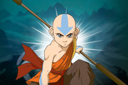

In [69]:
im = Image.open(dest)
im.to_thumb(128,128)

In [70]:
atla_types = 'aang','katara','zuko'
path = Path('atla')

In [71]:
if not path.exists():
    path.mkdir()
    for o in atla_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} avatar: the last airbender')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [72]:
fns = get_image_files(path)
fns

(#422) [Path('atla/aang/00000054.png'),Path('atla/aang/00000127.png'),Path('atla/aang/00000050.jpg'),Path('atla/aang/00000012.jpg'),Path('atla/aang/00000051.jpg'),Path('atla/aang/00000097.png'),Path('atla/aang/00000130.jpg'),Path('atla/aang/00000117.jpg'),Path('atla/aang/00000013.jpg'),Path('atla/aang/00000002.jpg')...]

In [73]:
failed = verify_images(fns)
failed

(#4) [Path('atla/zuko/00000064.jpg'),Path('atla/zuko/00000101.jpg'),Path('atla/katara/00000091.jpg'),Path('atla/katara/00000121.jpg')]

In [74]:
failed.map(Path.unlink);

In [75]:
atla = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [76]:
dls = atla.dataloaders(path)

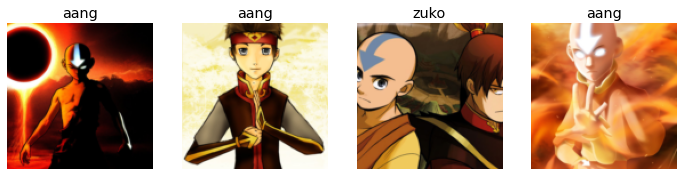

In [77]:
dls.valid.show_batch(max_n=4, nrows=1)

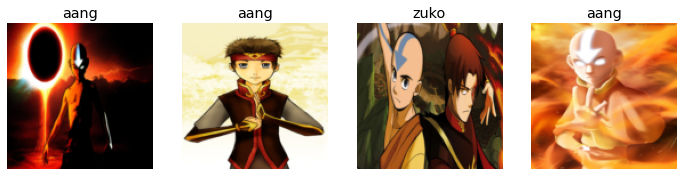

In [78]:
atla = atla.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = atla.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

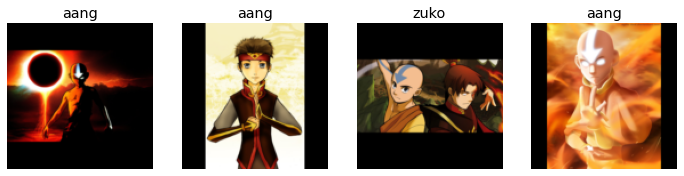

In [79]:
atla = atla.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = atla.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

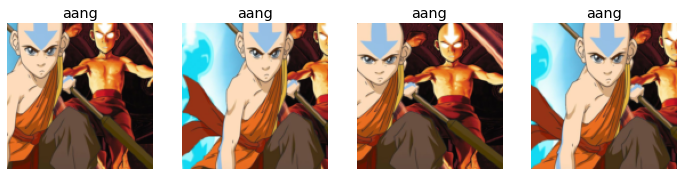

In [80]:
atla = atla.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = atla.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

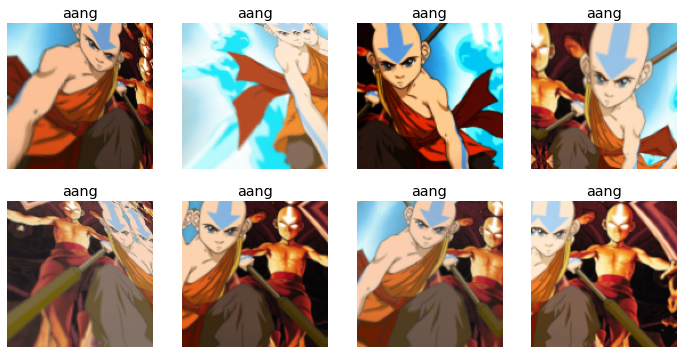

In [81]:
atla = atla.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = atla.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [82]:
atla = atla.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = atla.dataloaders(path)

In [83]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

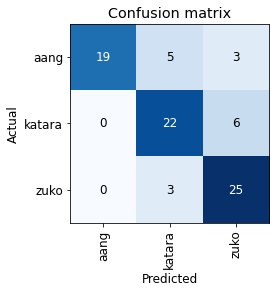

In [84]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

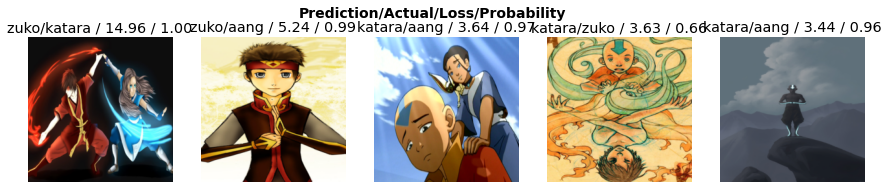

In [85]:
interp.plot_top_losses(5, nrows=1)

In [86]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [89]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [90]:
learn.export()

In [91]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [92]:
learn_inf = load_learner(path/'export.pkl')

In [94]:
learn_inf.predict('atla.jpg')

('aang', tensor(0), tensor([0.9857, 0.0017, 0.0125]))

In [95]:
learn_inf.dls.vocab

['aang', 'katara', 'zuko']

In [96]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [97]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['atla.jpg'])

In [99]:
img = PILImage.create(btn_upload.data[-1])

In [100]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [103]:
pred,pred_idx,probs = learn_inf.predict(img)

In [104]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: aang; Probability: 0.9857')

In [105]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [106]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [107]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [109]:
#hide_output
VBox([widgets.Label('Select your character!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [110]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6MB 3.0MB/s 
     |████████████████████████████████| 552kB 18.3MB/s 
     |████████████████████████████████| 122kB 17.5MB/s 
     |████████████████████████████████| 389kB 19.5MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: jupyter-server 1.8.0 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
